In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
import tensorflow as tf
from scipy.ndimage.measurements import center_of_mass
from tqdm import tqdm

# First a proof of concept

In [3]:
ev_signals = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-signals.csv', 
                header = 0, index_col = 0)
grid_signals = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-grid-signals.csv', 
                header = 0, index_col = 0)

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
set_session(tf.Session(config=config))

In [5]:
denoiser = load_model('denoising.h5')

In [6]:
sample_length = 32

dAE_output = np.zeros(len(grid_signals.iloc[0]))

for i in tqdm(range(len(dAE_output) - sample_length)):
    window = np.array(grid_signals.iloc[0].iloc[i:i+sample_length].values).reshape(1,sample_length,1)
    pred = denoiser.predict(window)
    dAE_output[i:i+sample_length] += pred.squeeze()

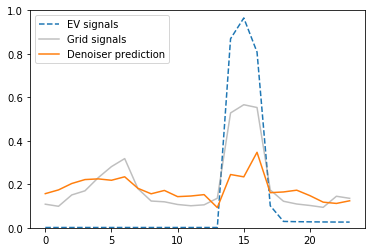

In [53]:
dice = np.random.randint(100)

day = 6*4
start = day*dice
end = day*(dice+1)
max_ev = np.max(ev_signals.iloc[0].values)
max_grid = np.max(grid_signals.iloc[0].values)
max_pred = np.max(dAE_output)

plt.plot(ev_signals.iloc[0][start:end].values / max_ev, label="EV signals", ls='--')
plt.plot(grid_signals.iloc[0][start:end].values / max_grid, label="Grid signals",
         color='grey', alpha=0.5)
plt.plot(dAE_output[start:end] / max_pred, label="Denoiser prediction")
plt.ylim(0,1)
plt.legend()
plt.show()

# Now the actual testing

In [54]:
data = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10houses.csv', 
                header = 0, index_col = 0)
data.index = data.index.map(lambda x: x[:-3])
data.index = pd.to_datetime(data.index)
data = data.astype(np.float64)

data2 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10more.csv', 
                header = 0, index_col = 0)
data2.index = data2.index.map(lambda x: x[:-3])
data2.index = pd.to_datetime(data2.index)
data2 = data2.astype(np.float64)
data = data.append(data2)

data3 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10more2.csv', 
                header = 0, index_col = 0)
data3.index = data3.index.map(lambda x: x[:-3])
data3.index = pd.to_datetime(data3.index)
data3 = data3.astype(np.float64)
data = data.append(data3)

data4 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10more3.csv', 
                header = 0, index_col = 0)
data4.index = data4.index.map(lambda x: x[:-3])
data4.index = pd.to_datetime(data4.index)
data4 = data4.astype(np.float64)
data = data.append(data4)

data5 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10more4.csv', 
                header = 0, index_col = 0)
data5.index = data5.index.map(lambda x: x[:-3])
data5.index = pd.to_datetime(data5.index)
data5 = data5.astype(np.float64)
data = data.append(data5)

data6 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-5last.csv', 
                header = 0, index_col = 0)
data6.index = data6.index.map(lambda x: x[:-3])
data6.index = pd.to_datetime(data6.index)
data6 = data6.astype(np.float64)
data = data.append(data6)


In [55]:
full_data_length = len(data[data['dataid'] == data['dataid'][0]])
houses = np.unique(data['dataid'])
testing_houses = []

for i in range(len(houses)):
    house_data = data[data['dataid'] == houses[i]]
    house_data_length = len(house_data)
    if house_data_length != full_data_length:
        testing_houses.append(houses[i])
        print("House {} is missing {} data points, starting at {} and ending at {}".format(houses[i], full_data_length - house_data_length, house_data.index[0], house_data.index[-1]))


House 545.0 is missing 303000 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 547.0 is missing 51300 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 1185.0 is missing 12420 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 1953.0 is missing 10826 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 2018.0 is missing 161940 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 2814.0 is missing 420 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 3723.0 is missing 349560 data points, starting at 2017-08-31 19:00:00 and ending at 2017-12-31 17:59:00
House 4336.0 is missing 41486 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 5357.0 is missing 558 data points, starting at 2017-01-01 00:00:00 and ending at 2017-12-31 17:59:00
House 5786.0 is missin

In [103]:
year = np.unique(data.index)
test_data = pd.DataFrame(index=year, columns=testing_houses)
test_ev_signals = pd.DataFrame(index=year, columns=testing_houses)


for i in range(len(testing_houses)):
    house_data = data[data['dataid'] == testing_houses[i]]
    house_data = house_data[~house_data.index.duplicated(keep='first')]
    house_data = house_data.reindex(test_data.index, fill_value = 0)

    test_data[testing_houses[i]] = house_data['grid']
    test_ev_signals[testing_houses[i]] = house_data['car1']

test_data = test_data.resample('15T').mean()
test_data.fillna(0,inplace=True)
test_ev_signals = test_ev_signals.resample('15T').mean()
test_ev_signals.fillna(0,inplace=True)
test_data.head()

,545.0,547.0,1185.0,1953.0,2018.0,2814.0,3723.0,4336.0,5357.0,5786.0,6139.0,6910.0
2017-01-01 00:00:00,0.681533,0.501067,0.620600,0.135267,0.956733,0.758867,0.0,6.561467,2.361867,1.232400,0.988933,0.283800
2017-01-01 00:15:00,0.617800,0.568867,0.680800,0.197733,0.827000,0.800933,0.0,6.429733,2.264000,1.693733,0.841000,0.256400
2017-01-01 00:30:00,0.666533,0.553867,0.691067,0.237867,0.706667,0.677867,0.0,6.525867,2.320467,1.065267,0.666467,0.331467
2017-01-01 00:45:00,0.592867,0.519867,0.608000,0.227600,0.810400,0.620733,0.0,6.432933,2.237333,0.985800,0.630333,0.315067
2017-01-01 01:00:00,0.655533,0.568400,0.632933,0.224867,0.834000,0.527533,0.0,6.422667,2.218667,0.918133,0.604733,0.261267


In [510]:
def find_signals(data, model, normalization_std = 1, threshold=0.2, mode='same', sample_length=32):
    #Finds the events corresponding to a cross correlation between the data and at least one template of above threshold.

    timeline = pd.DataFrame(np.zeros(data.shape[0]),index = data.index)
    
    data_val = data.values.copy()
    model_output = np.zeros(len(data))
    
    data_val -= data_val.mean()
    data_val /= normalization_std
    
    for i in range(len(model_output) - sample_length):
        window = np.array(data_val[i:i+sample_length]).reshape(1,sample_length,1)
        pred = model.predict(window)
        model_output[i:i+sample_length] += pred.squeeze()
    
    #timeline += model_output[:,np.newaxis]
    
#     for i in range(len(timeline)):
#         if model_output[i] > threshold:
#             timeline.iloc[i] += model_output[i]
        
    i=0
    while i < len(model_output):
        start = i
        if model_output[i] > threshold:
            while i < len(model_output) and model_output[i] > threshold:
                i+=1
            signal_peak = start + int((model_output[start:i]).argmax())
#             timeline.iloc[start:i] -= timeline.iloc[start:i]
            timeline.iloc[signal_peak] +=1
            #timeline.iloc[int((i+start)/2)] += 1 
        else:
            i+=1
    
    return timeline.where(timeline > 0).dropna().index

def get_signatures(power_series, min_off_duration = 0, min_on_duration = 3):
    
    signatures = []
    current_signal = []
    starts = []
    peak_times = []
    off_duration = 0
    
    for i in range(1,power_series.size):
  
        if power_series[i] > 1:
            if len(current_signal) == 0:
                if i == 0:
                    current_signal.append(0)
                else:
                    current_signal.append(power_series[i-1])
            current_signal.append(power_series[i])
            off_duration = 0
        else:
            off_duration += 1
            if off_duration >= min_off_duration and len(current_signal) > min_on_duration:
                if i >= len(current_signal) - 1:
                    current_signal.append(0)
                else:
                    current_signal.append(power_series[i+1])
                signatures.append(current_signal)
                starts.append(power_series.index[i-len(current_signal)])
                peak_times.extend(power_series.index[i-len(current_signal):i])
                current_signal = []
            
    return signatures, starts, pd.to_datetime(peak_times)


def filter_score(signal_times, signals_hat, peak_times):
    n_signals = len(peak_times)
    #True positives
    tp = np.where(np.in1d(signals_hat,signal_times))[0].shape[0]
    #False positives
    fp = np.where(np.in1d(signals_hat,signal_times,invert=True))[0].shape[0]
    #Precision
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    
    #Recall
    
    found_peaks = 0
    for i in range(len(peak_times)):
        if np.in1d(pd.Series(peak_times[i]), signals_hat).any():
            found_peaks +=1
    
    recall = found_peaks/n_signals
    #F1-measure
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = (2*precision*recall) / (precision + recall)
    #print('Precision: {}\nRecall: {}\nF1-score: {}'.format(precision,recall,f1))
    
    return precision,recall,f1



In [105]:
y = []

for house in test_data.columns:
    s = get_signatures(test_ev_signals[house])
    if len(s[1]) > 0:
        y.append(s)
    else:
        test_ev_signals.drop(columns=house, inplace=True)
        test_data.drop(columns=house, inplace=True)
        
normalization_params = pd.read_csv('normalization_params_dAE.csv', header = 0)
normalization_mean = normalization_params['mean']
normalization_std = float(normalization_params['sd'])
normalization_params

,Unnamed: 0,mean,sd
0,0,[[[ 0. ]]\r\n\r\n [[ 1.7237125 ]]\r\n\r...,1.709083


In [543]:
threshold = np.linspace(10,100,5)
y_hat = [[] for _ in range(len(test_data.columns))]

for t in threshold:
    house_scores = []
    house_recalls = []
    house_precisions = []
    
    for i in tqdm(range(len(test_data.columns))):
        y_hat[i].append(find_signals(test_data[test_data.columns[i]], denoiser, normalization_std = normalization_std, 
                                     threshold=t))
        
        score = filter_score(y[i][2],y_hat[i][-1],peak_times_discretized[i])
        house_scores.append(score[2])
        house_recalls.append(score[1])
        house_precisions.append(score[0])
    
    print("Threshold {} done".format(t))
    print("House precision: {}\nRecall: {}\nF1: {}".format(np.mean(house_precisions), np.mean(house_recalls), 
                                                           np.mean(house_scores)))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:30<00:00, 30.06s/it]


Threshold 10.0 done
House precision: 0.21128187698017753
Recall: 0.8996117126718614
F1: 0.32456016187002185


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:37<00:00, 30.70s/it]


Threshold 32.5 done
House precision: 0.3511447420895077
Recall: 0.8922787514214416
F1: 0.479734500847335


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:26<00:00, 29.69s/it]


Threshold 55.0 done
House precision: 0.43112822351900076
Recall: 0.854832218109032
F1: 0.5405398057929985


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [07:34<00:00, 41.33s/it]


Threshold 77.5 done
House precision: 0.5077828925760806
Recall: 0.7409083608642475
F1: 0.5588955735271787


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [11:10<00:00, 60.97s/it]


Threshold 100.0 done
House precision: 0.6411370821068276
Recall: 0.6083498364352203
F1: 0.5539367044673646


In [504]:
y_hat[0][0]

DatetimeIndex(['2017-01-01 14:00:00', '2017-01-02 14:30:00',
               '2017-01-03 17:30:00', '2017-01-04 17:30:00',
               '2017-01-05 18:30:00', '2017-01-06 11:00:00',
               '2017-01-07 13:45:00', '2017-01-08 13:00:00',
               '2017-01-09 17:30:00', '2017-01-10 13:45:00',
               ...
               '2017-12-21 12:45:00', '2017-12-22 11:30:00',
               '2017-12-23 13:30:00', '2017-12-24 08:15:00',
               '2017-12-25 13:45:00', '2017-12-26 13:45:00',
               '2017-12-27 14:00:00', '2017-12-28 13:45:00',
               '2017-12-29 17:45:00', '2017-12-30 17:45:00'],
              dtype='datetime64[ns]', length=145, freq=None)

In [397]:
peak_times_discretized = []

for house in y:
    house_peaks = []
    peak_package = [house[2][0]]
    for time in house[2][1:]:
        if time - peak_package[-1] > pd.Timedelta('15min'):
            house_peaks.append(peak_package)
            peak_package = []
        peak_package.append(time)
    peak_times_discretized.append(house_peaks)

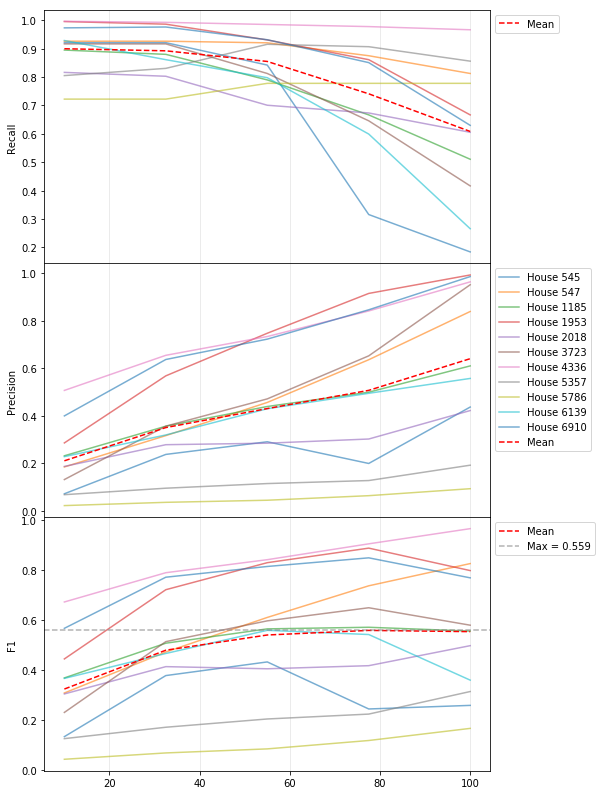

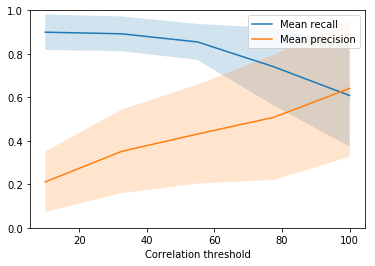

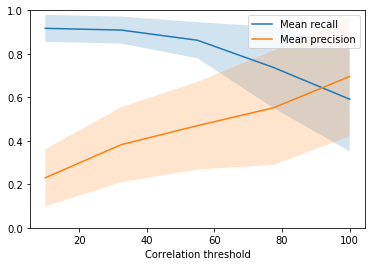

In [544]:
house_scores = [[] for _ in range(len(y_hat))]
house_recalls = [[] for _ in range(len(y_hat))]
house_precisions = [[] for _ in range(len(y_hat))]

fig, ax = plt.subplots(3, 1, sharey='row', sharex='col') 
fig.set_size_inches(8,14)
plt.subplots_adjust(hspace=0.0)

for i in range(len(y_hat)):
    for j in range(len(y_hat[i])):
        score = filter_score(y[i][2],y_hat[i][j],peak_times_discretized[i])
        house_scores[i].append(score[2])
        house_recalls[i].append(score[1])
        house_precisions[i].append(score[0])
        
    ax[0].plot(threshold,house_recalls[i], alpha=0.6)
    ax[1].plot(threshold,house_precisions[i], label="House {}".format(int(test_data.columns[i])), alpha=0.6)
    ax[2].plot(threshold,house_scores[i], alpha=0.6)

ax[0].plot(threshold,np.mean(house_recalls, axis=0), '--r', label="Mean")
ax[1].plot(threshold,np.mean(house_precisions, axis=0), '--r', label="Mean")
ax[2].plot(threshold,np.mean(house_scores, axis=0), '--r', label="Mean")
ax[2].axhline(np.max(np.mean(house_scores, axis=0)), linestyle='--', color='grey', label="Max = {:1.3f}".format(np.max(np.mean(house_scores,axis=0))), alpha=0.6)

ax[0].legend(bbox_to_anchor=(1,1))
ax[1].legend(bbox_to_anchor=(1,1))
ax[2].legend(bbox_to_anchor=(1,1))

ax[0].grid(axis='x', alpha=0.3)
ax[1].grid(axis='x', alpha=0.3)
ax[2].grid(axis='x', alpha=0.3)

ax[0].set_ylabel("Recall")
ax[1].set_ylabel("Precision")
ax[2].set_ylabel("F1")

# ax[0].set_xlim(0,1)
# ax[1].set_xlim(0,1)
# ax[2].set_xlim(0,1)

plt.show()

# Only precision and recall:

rec_std = np.std(house_recalls, axis=0)
rec_mean = np.mean(house_recalls, axis=0)

prec_std = np.std(house_precisions, axis=0)
prec_mean = np.mean(house_precisions, axis=0)

f1_std = np.std(house_scores, axis=0)
f1_mean = np.mean(house_scores, axis=0)

plt.plot(threshold,rec_mean,  label="Mean recall")
plt.plot(threshold,prec_mean, label="Mean precision")
#plt.plot(threshold,f1_mean, label="Mean")

plt.fill_between(threshold, rec_mean - rec_std, rec_mean + rec_std, alpha=0.2)
plt.fill_between(threshold, prec_mean - prec_std, prec_mean + prec_std, alpha=0.2)
#plt.fill_between(threshold, rec_mean - rec_std, rec_mean + rec_std, alpha=0.2)

plt.ylim(0,1)
plt.legend()
plt.xlabel("Correlation threshold")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\neural_nets\\dAE_precision_recall.svg')
plt.show()

# Without outlier 
rec_std = np.std(np.concatenate((house_recalls[:8], house_recalls[9:])), axis=0)
rec_mean = np.mean(np.concatenate((house_recalls[:8], house_recalls[9:])), axis=0)

prec_std = np.std(np.concatenate((house_precisions[:8], house_precisions[9:])), axis=0)
prec_mean = np.mean(np.concatenate((house_precisions[:8], house_precisions[9:])), axis=0)

f1_std = np.std(house_scores[:8] + house_recalls[9:], axis=0)
f1_mean = np.mean(house_scores[:8] + house_recalls[9:], axis=0)

plt.plot(threshold,rec_mean,  label="Mean recall")
plt.plot(threshold,prec_mean, label="Mean precision")
#plt.plot(threshold,f1_mean, label="Mean")

plt.fill_between(threshold, rec_mean - rec_std, rec_mean + rec_std, alpha=0.2)
plt.fill_between(threshold, prec_mean - prec_std, prec_mean + prec_std, alpha=0.2)
#plt.fill_between(threshold, rec_mean - rec_std, rec_mean + rec_std, alpha=0.2)

plt.ylim(0,1)
plt.legend()
plt.xlabel("Correlation threshold")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\neural_nets\\dAE_precision_recall_no_outlier.svg')
plt.show()

In [546]:
c = 1

for i in range(11):
    print("{:.2f} | {:.2f} | {:.2f} | {:.2f}".format(house_precisions[i][c], house_recalls[i][c], house_scores[i][c], len(y_hat[i][c])))


0.24 | 0.92 | 0.38 | 168.00
0.32 | 0.93 | 0.47 | 539.00
0.36 | 0.88 | 0.51 | 922.00
0.57 | 0.99 | 0.72 | 392.00
0.28 | 0.80 | 0.41 | 448.00
0.36 | 0.92 | 0.51 | 126.00
0.66 | 0.99 | 0.79 | 412.00
0.10 | 0.83 | 0.17 | 1043.00
0.04 | 0.72 | 0.07 | 385.00
0.32 | 0.86 | 0.47 | 728.00
0.64 | 0.98 | 0.77 | 530.00


In [520]:
house_precisions

[[0.4375, 0.8333333333333334, 1.0, 1.0, 1.0],
 [0.8397790055248618,
  0.9139072847682119,
  0.9124087591240876,
  0.9504132231404959,
  0.9439252336448598],
 [0.6107594936708861,
  0.7005649717514124,
  0.788235294117647,
  0.8936170212765957,
  0.9545454545454546],
 [0.9935897435897436, 1.0, 1.0, 1.0, 1.0],
 [0.42272727272727273,
  0.4900662251655629,
  0.4666666666666667,
  0.5773195876288659,
  0.7777777777777778],
 [0.9523809523809523, 1.0, 1.0, 0, 0],
 [0.9645390070921985, 0.9924812030075187, 1.0, 1.0, 1.0],
 [0.19272727272727272,
  0.2774566473988439,
  0.37662337662337664,
  0.6068376068376068,
  0.8243243243243243],
 [0.09375,
  0.14018691588785046,
  0.1686746987951807,
  0.19696969696969696,
  0.24528301886792453],
 [0.5579710144927537, 0.55, 0.9411764705882353, 1.0, 1.0],
 [0.986784140969163, 1.0, 1.0, 1.0, 1.0]]

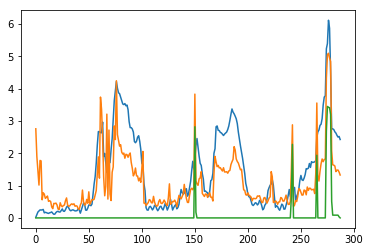

In [405]:
week = day*7
dice = 0
start = day*dice
end = day*(dice+12)

plt.plot(dAE_output[start:end].squeeze() / 32)
plt.plot(grid_signals.iloc[0][start:end].values)
plt.plot(ev_signals.iloc[0][start:end].values)

matches = np.where(np.in1d(pd.to_datetime(grid_signals.iloc[0].index), np.array(y_hat[0][0])))[0]

for line in matches[np.where(matches < end - start)]:
    print(line)
    plt.axvline(line, color='red', ls='--')
plt.show()

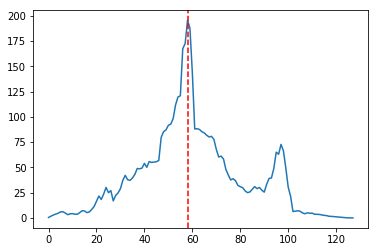

In [509]:
j = (250 - sample_length)
agg = np.zeros(sample_length*4)
for i in range(j, j+sample_length*3):
    window = np.array(grid_signals.iloc[0].iloc[i:i+sample_length].values).reshape(1,sample_length,1)
    pred = denoiser.predict(window)
#     plt.plot(ev_signals.iloc[0][i:i+sample_length].values)
#     plt.plot(window.squeeze(), color='grey', alpha=0.5)
#     plt.plot(pred.squeeze())
#     plt.show()
    k = pred.squeeze()
    
    agg[i - j:i - j + sample_length] += k
plt.plot(agg)
plt.axvline(np.argmax(agg), color='red', ls='--')
plt.show()